# 🤝 IID Client Data Distribution
This notebook simulates an IID (Independent and Identically Distributed) data split across federated clients, ensuring each client receives balanced and representative class data.

---

[INFO] ✅ Total GOOD files found: 11025
[INFO] ✅ Total BAD  files found: 11619

[INFO] 🎯 Reserving 100 GOOD and 100 BAD files for the test set...
[INFO] ✍️ Saving test files to '../../resources/material/train-data/federated/IID/test_clients' and writing test label CSV...
[INFO] ✅ Test set created with total: 100 GOOD + 100 BAD = 200 files

[INFO] 🔄 Each client will receive: 2185 GOOD + 2185 BAD files.
[INFO] 📁 Distributing files to client_1...
    └─ GOOD: 2185, BAD: 2185
[INFO] 📁 Distributing files to client_2...
    └─ GOOD: 2185, BAD: 2185
[INFO] 📁 Distributing files to client_3...
    └─ GOOD: 2185, BAD: 2185
[INFO] 📁 Distributing files to client_4...
    └─ GOOD: 2185, BAD: 2185
[INFO] 📁 Distributing files to client_5...
    └─ GOOD: 2185, BAD: 2185

[SUMMARY]
🟢 Total GOOD files used: 11025 / 11025
🔴 Total BAD  files used: 11025 / 11619
🧪 Test set: 100 GOOD + 100 BAD
👤 client_1: 2185 GOOD + 2185 BAD
👤 client_2: 2185 GOOD + 2185 BAD
👤 client_3: 2185 GOOD + 2185 BAD
👤 client_4: 2185 

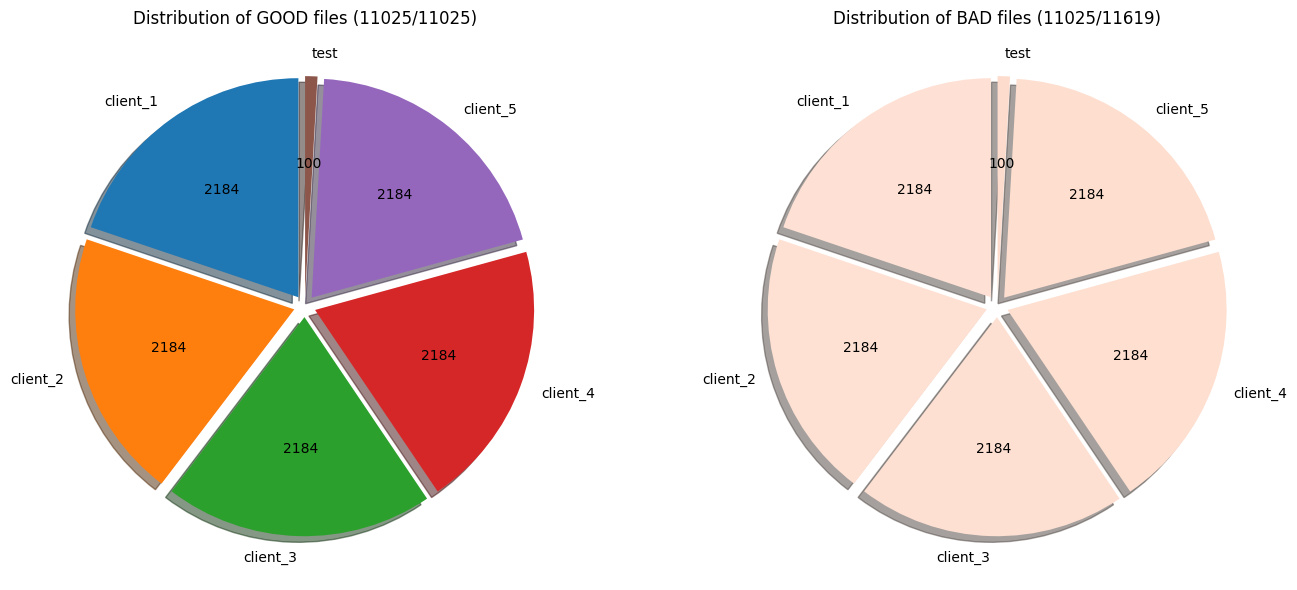

In [ ]:
import os
import shutil
import random
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt

def list_wav_files(directory: str) -> List[str]:
    return sorted([f for f in os.listdir(directory) if f.endswith(".wav")])

def chunkify(lst: List[str], num_chunks: int) -> List[List[str]]:
    avg = len(lst) // num_chunks
    chunks = [lst[i * avg: (i + 1) * avg] for i in range(num_chunks - 1)]
    chunks.append(lst[(num_chunks - 1) * avg:])
    return chunks

def distribute_iid_clients_with_test(
    good_dir: str,
    bad_dir: str,
    output_base_dir: str,
    num_clients: int = 5,
    test_samples_per_class: int = 100,
    seed: int = 42
):
    random.seed(seed)
    output_base = Path(output_base_dir)
    test_dir = output_base / "test_clients"
    test_dir.mkdir(parents=True, exist_ok=True)

    # === Step 1: Load files ===
    good_files = list_wav_files(good_dir)
    bad_files = list_wav_files(bad_dir)

    original_good = len(good_files)
    original_bad = len(bad_files)
    print(f"[INFO] ✅ Total GOOD files found: {original_good}")
    print(f"[INFO] ✅ Total BAD  files found: {original_bad}")

    # === Step 2: Extract Test Set ===
    print(f"\n[INFO] 🎯 Reserving {test_samples_per_class} GOOD and {test_samples_per_class} BAD files for the test set...")

    random.shuffle(good_files)
    random.shuffle(bad_files)
    test_good = good_files[:test_samples_per_class]
    test_bad = bad_files[:test_samples_per_class]
    good_files = good_files[test_samples_per_class:]
    bad_files = bad_files[test_samples_per_class:]

    # === Step 3: Copy test files and log ===
    print(f"[INFO] ✍️ Saving test files to '{test_dir}' and writing test label CSV...")
    with open(test_dir / "labels.csv", "w") as f:
        f.write("filename,label\n")
        for file in test_good:
            shutil.copy2(Path(good_dir) / file, test_dir / file)
            f.write(f"{file},good\n")
        for file in test_bad:
            shutil.copy2(Path(bad_dir) / file, test_dir / file)
            f.write(f"{file},bad\n")

    print(f"[INFO] ✅ Test set created with total: {len(test_good)} GOOD + {len(test_bad)} BAD = {len(test_good) + len(test_bad)} files\n")

    # === Step 4: Distribute to Clients ===
    files_per_client_per_class = min(len(good_files), len(bad_files)) // num_clients
    print(f"[INFO] 🔄 Each client will receive: {files_per_client_per_class} GOOD + {files_per_client_per_class} BAD files.")

    good_files = good_files[:files_per_client_per_class * num_clients]
    bad_files = bad_files[:files_per_client_per_class * num_clients]
    good_chunks = chunkify(good_files, num_clients)
    bad_chunks = chunkify(bad_files, num_clients)

    client_distribution = {}

    for i in range(num_clients):
        client_id = f"client_{i+1}"
        client_dir = output_base / client_id
        (client_dir / "good").mkdir(parents=True, exist_ok=True)
        (client_dir / "bad").mkdir(parents=True, exist_ok=True)

        print(f"[INFO] 📁 Distributing files to {client_id}...")
        for f in good_chunks[i]:
            shutil.copy2(Path(good_dir) / f, client_dir / "good" / f)
        for f in bad_chunks[i]:
            shutil.copy2(Path(bad_dir) / f, client_dir / "bad" / f)

        client_distribution[client_id] = {
            "good": len(good_chunks[i]),
            "bad": len(bad_chunks[i])
        }
        print(f"    └─ GOOD: {len(good_chunks[i])}, BAD: {len(bad_chunks[i])}")

    # === Summary Print ===
    total_used_good = len(test_good) + sum(len(chunk) for chunk in good_chunks)
    total_used_bad = len(test_bad) + sum(len(chunk) for chunk in bad_chunks)

    print(f"\n[SUMMARY]")
    print(f"🟢 Total GOOD files used: {total_used_good} / {original_good}")
    print(f"🔴 Total BAD  files used: {total_used_bad} / {original_bad}")
    print(f"🧪 Test set: {len(test_good)} GOOD + {len(test_bad)} BAD")
    for client, counts in client_distribution.items():
        print(f"👤 {client}: {counts['good']} GOOD + {counts['bad']} BAD")

    return {
        "original_good": original_good,
        "original_bad": original_bad,
        "test_good": len(test_good),
        "test_bad": len(test_bad),
        "clients": client_distribution
    }


def plot_distribution_pies(summary):
    import matplotlib.pyplot as plt

    labels = list(summary["clients"].keys()) + ["test"]
    good_sizes = [summary["clients"][k]["good"] for k in summary["clients"]]
    bad_sizes = [summary["clients"][k]["bad"] for k in summary["clients"]]
    good_sizes.append(summary["test_good"])
    bad_sizes.append(summary["test_bad"])

    total_good_used = sum(good_sizes)
    total_bad_used = sum(bad_sizes)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    explode = [0.05]*len(labels)

    # Good pie
    axs[0].pie(
        good_sizes,
        labels=labels,
        autopct=lambda p: f'{int(p * total_good_used / 100)}',
        explode=explode,
        startangle=90,
        shadow=True
    )
    axs[0].set_title(f"Distribution of GOOD IID files ({total_good_used}/{summary['original_good']})")

    # Bad pie
    axs[1].pie(
        bad_sizes,
        labels=labels,
        autopct=lambda p: f'{int(p * total_bad_used / 100)}',
        explode=explode,
        startangle=90,
        shadow=True,
        colors=plt.cm.Reds(range(30, 30 + len(labels)*5))
    )
    axs[1].set_title(f"Distribution of BAD IID files ({total_bad_used}/{summary['original_bad']})")

    plt.tight_layout()
    plt.show()

summary = distribute_iid_clients_with_test(
    good_dir="../../resources/material/train-data/augmented-good-material-taps",
    bad_dir="../../resources/material/train-data/augmented-bad-material-taps",
    output_base_dir="../../resources/material/train-data/federated/IID",
    num_clients=5,
    test_samples_per_class=100
)

plot_distribution_pies(summary)


In [16]:
# Run and get returned values
test_good, test_bad, good_chunks, bad_chunks = distribute_iid_clients_with_test(
    good_dir="../../resources/material/train-data/augmented-good-material-taps",
    bad_dir="../../resources/material/train-data/augmented-bad-material-taps",
    output_base_dir="../../resources/material/train-data/federated/IID",
    num_clients=5,
    test_samples_per_class=100
)

[INFO] Total Good Files Available: 11025
[INFO] Total Bad  Files Available: 11619

🧪 Created test set:
   └─ Good files: 100
   └─ Bad  files: 100
   └─ labels.csv created in test_clients/

📦 Client 1
   └─ Good files: 2185
   └─ Bad  files: 2185

📦 Client 2
   └─ Good files: 2185
   └─ Bad  files: 2185

📦 Client 3
   └─ Good files: 2185
   └─ Bad  files: 2185

📦 Client 4
   └─ Good files: 2185
   └─ Bad  files: 2185

📦 Client 5
   └─ Good files: 2185
   └─ Bad  files: 2185

✅ Distributed 2185 good + 2185 bad files per client across 5 clients.
✅ Test set with 100 good + 100 bad files created in 'test_clients/'.


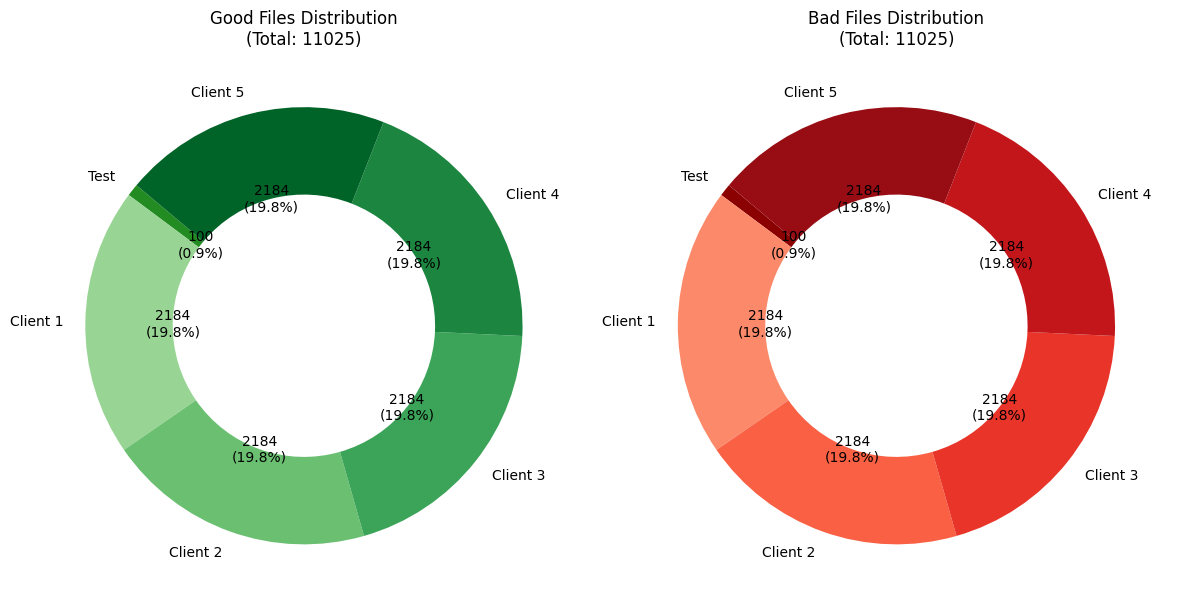

In [14]:
# Plot  full good bad distribution
plot_full_good_bad_distribution(
    base_dir="../../resources/material/train-data/federated/IID",
    num_clients=5
)
